<a href="https://colab.research.google.com/github/mkorlyakova/Time-Series-Prediction/blob/master/Time_series_PJME_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install modul


In [1]:
!pip install statsmodels==0.11.1

     |████████████████████████████████| 8.7MB 3.6MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [2]:
!pip install catboost

     |████████████████████████████████| 66.1MB 45kB/s 


In [3]:
!pip install holidays

Import all progect modules

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns


from sklearn.metrics import mean_squared_error
import os


import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt


from statsmodels.tsa.seasonal import STL

from statsmodels.datasets import elec_equip as ds


In [5]:
import os
#os.system("pip install holidays")
import holidays

In [6]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from datetime import timedelta
one_hours = timedelta(hours=1)
one_day = timedelta(days=1)

In [7]:
from sklearn.linear_model import LinearRegression

In [8]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score

from catboost import CatBoostRegressor 


In [9]:
from tensorflow.keras import utils
import numpy as np
import tensorflow.keras as keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM


from tensorflow.keras.callbacks import EarlyStopping

1. Читаем с локального диска данные

In [10]:
!git clone -l -s https://github.com/mkorlyakova/Time-Series-Prediction.git cloned-repo

!ls

Cloning into 'cloned-repo'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 6 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (6/6), done.
cloned-repo  sample_data


Читаем данные в память - причесываем немного и берем для работы 1-й столбец (остальные можно было бы убрать)

In [11]:

Path_Energy = '/content/cloned-repo/PJME_hourly.csv'
data = pd.read_csv(Path_Energy, index_col=[0], parse_dates=[0])


data.sort_index(inplace=True)
#data.drop('Time',axis=1, inplace =True)
data.head()

,PJME_MW
Datetime,
2002-01-01 01:00:00,30393.0
2002-01-01 02:00:00,29265.0
2002-01-01 03:00:00,28357.0
2002-01-01 04:00:00,27899.0
2002-01-01 05:00:00,28057.0


# Анализ данных

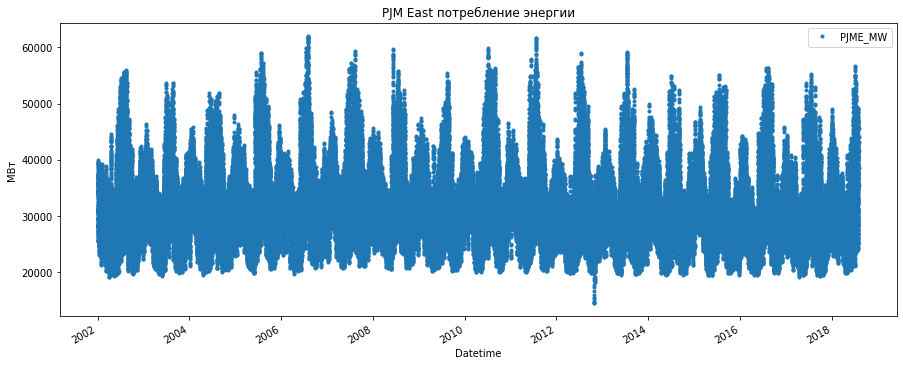

In [12]:
data.plot(style='.', figsize=(15, 6), title='PJM East потребление энергии')
plt.ylabel('МВт');

In [13]:
data.describe()

,PJME_MW
count,145366.000000
mean,32080.222831
std,6464.012166
min,14544.000000
25%,27573.000000
50%,31421.000000
75%,35650.000000
max,62009.000000


In [14]:
# float to int

data['PJME_MW'] = data['PJME_MW'].astype('int64')

 **Обсуждение визуализации**

- Основные статистики показали, что явных пропусков нет
- Визуальный анализ показывает что:
    - Предъявленные данные имеют циклы
    - Конец 2012 года ознаменовался каким-то провалом потребления. Добавим колонку с датой data['date'] = data.index. Посмотрим ближе на необычное поведение ряда и для этого воспользуемся конструкцией извлечения информации из DatetimeIndex в форме .dt.year -получить год, .dt.month - месяц и  .dt.day - день. Организуем таблицу с сомнительным эпизодом data_2012 

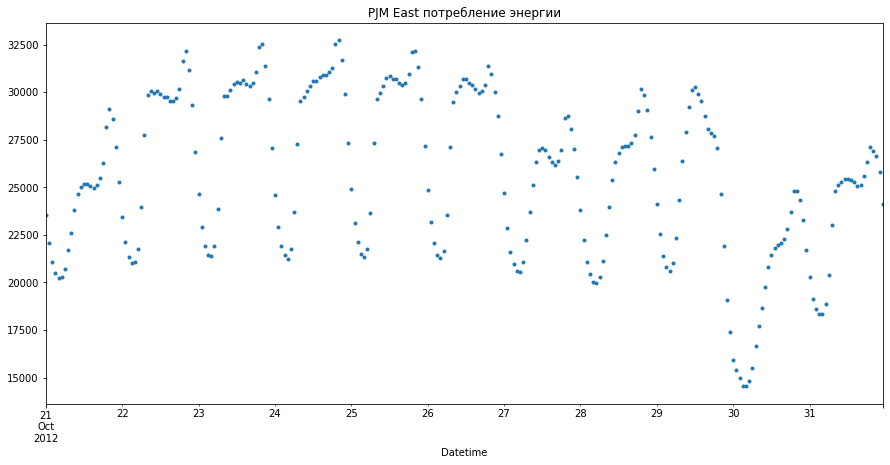

In [15]:

data['date'] = data.index
data_2012 = data.loc[np.logical_and( np.logical_and( data['date'].dt.year == 2012 , data['date'].dt.month == 10), data['date'].dt.day > 20  )]

_ = data_2012['PJME_MW'].plot( style='.', figsize=( 15, 7 ), title='PJM East потребление энергии' )

Проверили - это был ураган 30.10.2011

In [16]:
data['date'] = data.index
data.head()

,PJME_MW,date
Datetime,,
2002-01-01 01:00:00,30393,2002-01-01 01:00:00
2002-01-01 02:00:00,29265,2002-01-01 02:00:00
2002-01-01 03:00:00,28357,2002-01-01 03:00:00
2002-01-01 04:00:00,27899,2002-01-01 04:00:00
2002-01-01 05:00:00,28057,2002-01-01 05:00:00


Test date field

In [17]:
count_data = data['date'].value_counts()
count_data.head()

2014-11-02 02:00:00    2
2015-11-01 02:00:00    2
2016-11-06 02:00:00    2
2017-11-05 02:00:00    2
2012-08-16 00:00:00    1
Name: date, dtype: int64

Double date in PJME_MW - summer/winter time 

clear this case:

In [18]:
data_time_h = pd.date_range(data.index[0],data.index[-1],freq='H')

time_lost = np.where(np.isin(data_time_h.values, data['date'].values)==False)
data_time_h[time_lost]

DatetimeIndex(['2002-04-07 03:00:00', '2002-10-27 02:00:00',
               '2003-04-06 03:00:00', '2003-10-26 02:00:00',
               '2004-04-04 03:00:00', '2004-10-31 02:00:00',
               '2005-04-03 03:00:00', '2005-10-30 02:00:00',
               '2006-04-02 03:00:00', '2006-10-29 02:00:00',
               '2007-03-11 03:00:00', '2007-11-04 02:00:00',
               '2008-03-09 03:00:00', '2008-11-02 02:00:00',
               '2009-03-08 03:00:00', '2009-11-01 02:00:00',
               '2010-03-14 03:00:00', '2010-11-07 02:00:00',
               '2010-12-10 00:00:00', '2011-03-13 03:00:00',
               '2011-11-06 02:00:00', '2012-03-11 03:00:00',
               '2012-11-04 02:00:00', '2013-03-10 03:00:00',
               '2013-11-03 02:00:00', '2014-03-09 03:00:00',
               '2015-03-08 03:00:00', '2016-03-13 03:00:00',
               '2017-03-12 03:00:00', '2018-03-11 03:00:00'],
              dtype='datetime64[ns]', freq=None)

In [19]:
 # calculate lost value of consumption
 v = np.round((data.loc[data_time_h[time_lost]-one_hours]['PJME_MW'].values+data.loc[data_time_h[time_lost]+one_hours]['PJME_MW'].values)/2).reshape(-1,1)
 

In [20]:
 #lost value of consumption in table
df_data = pd.DataFrame(data = v, index=data_time_h[time_lost],columns=['PJME_MW'])
df_data['date']=data_time_h[time_lost]
df_data.head()


,PJME_MW,date
2002-04-07 03:00:00,24612.0,2002-04-07 03:00:00
2002-10-27 02:00:00,21714.0,2002-10-27 02:00:00
2003-04-06 03:00:00,23124.0,2003-04-06 03:00:00
2003-10-26 02:00:00,21822.0,2003-10-26 02:00:00
2004-04-04 03:00:00,23354.0,2004-04-04 03:00:00


In [21]:
 # conect data and df_data
data=pd.concat([data,df_data],join = 'inner')
data.sort_index(inplace=True)

In [22]:
# delete dublicate time row
data.drop_duplicates()
data.shape

(145396, 2)

In [23]:
data.tail()

,PJME_MW,date
2018-08-02 20:00:00,44057.0,2018-08-02 20:00:00
2018-08-02 21:00:00,43256.0,2018-08-02 21:00:00
2018-08-02 22:00:00,41552.0,2018-08-02 22:00:00
2018-08-02 23:00:00,38500.0,2018-08-02 23:00:00
2018-08-03 00:00:00,35486.0,2018-08-03 00:00:00


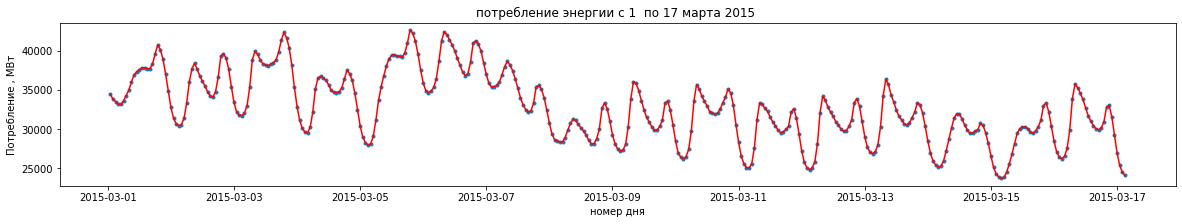

In [24]:
plt.figure(figsize=(20,3))
plt.plot(data['2015-03-01 01:00:00':'2015-03-17 03:00:00'].index,data['2015-03-01 01:00:00':'2015-03-17 03:00:00']['PJME_MW'].values, '.')
plt.plot(data['2015-03-01 01:00:00':'2015-03-17 03:00:00'].index,data['2015-03-01 01:00:00':'2015-03-17 03:00:00']['PJME_MW'].values, 'r')

plt.xlabel('номер дня')
plt.ylabel('Потребление , МВт')
plt.title('потребление энергии с 1  по 17 марта 2015 ')
plt.show()

Убрали пропуски и дубли 

# Строим признаки

Добавляем новых признаков

In [25]:
#New features

data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['dayofmonth'] = data['date'].dt.day
data['quarter'] = data['date'].dt.quarter
data['dayofyear'] = data['date'].dt.dayofyear
data['weekofyear'] = data['date'].dt.weekofyear
data['dayofweek'] = data['date'].dt.dayofweek
data['hour'] = data['date'].dt.hour

In [26]:
# теперь уберем служебную колонку data
data.drop( columns = 'date', inplace = True )
data.head()

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour
2002-01-01 01:00:00,30393.0,2002,1,1,1,1,1,1,1
2002-01-01 02:00:00,29265.0,2002,1,1,1,1,1,1,2
2002-01-01 03:00:00,28357.0,2002,1,1,1,1,1,1,3
2002-01-01 04:00:00,27899.0,2002,1,1,1,1,1,1,4
2002-01-01 05:00:00,28057.0,2002,1,1,1,1,1,1,5


Создаем модель для анализа сезонности :
- вычисление тренда
- подбор сглаживания
- оценка остатков



32078.642851247627 -0.009399857149792397


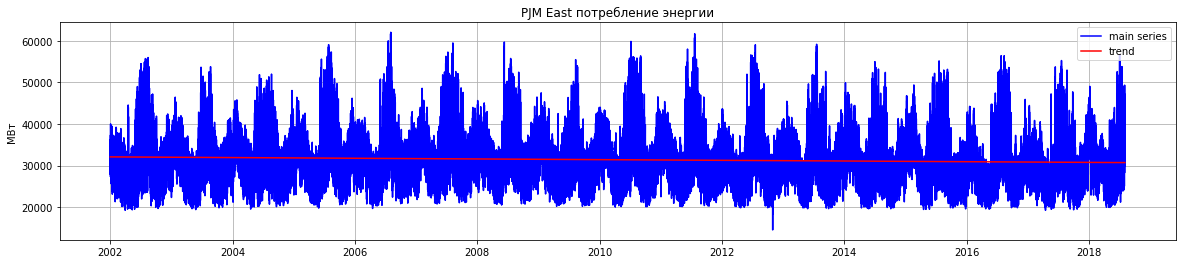

In [27]:
y= data['PJME_MW'].values
x1 = np.array(range(data.shape[0]))

Lin_mod = LinearRegression()
Lin_mod.fit(x1.reshape(-1, 1),y.reshape(-1, 1))

W1 =Lin_mod.coef_[0,0]
W0 =y.mean()
print(W0,W1)

plt.figure(figsize =(20,4))
plt.plot( data.index, data['PJME_MW'], 'b' , label ='main series')
plt.plot( data.index[[0,-1]], [W0+W1*x1[0] , W0+W1*x1[-1]], 'r',label='trend' )
plt.title('PJM East потребление энергии' )
plt.legend()
plt.grid()
plt.ylabel ( 'МВт' )
plt.show()

In [28]:
# Считаем тренд
Trend = W0+W1*x1

In [29]:
# добавим признак - данные без тренда (он маленький, но есть)
data['PJME_MW no trend'] = y - W0-W1*x1

Ищу циклы:

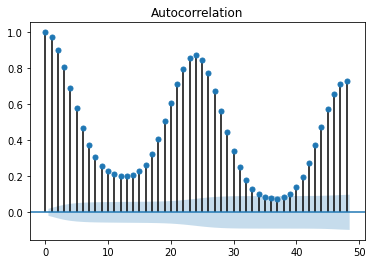

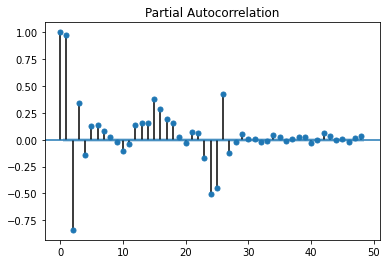

In [30]:
#plt.figure(figsize=(20,8))
#plt.subplot(2,1,1)
sm.graphics.tsa.plot_acf(data['PJME_MW'].values[:10000], lags=24*2)
plt.show()

#plt.subplot(2,1,2)
sm.graphics.tsa.plot_pacf(data['PJME_MW'].values[:10000], lags=24*2)
plt.show()

24h cicle

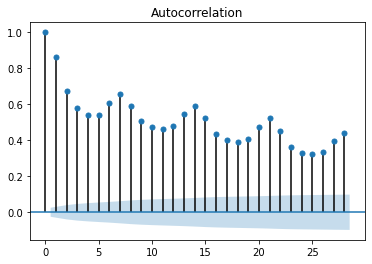

In [31]:
data_d = data.resample('D').mean()
sm.graphics.tsa.plot_acf(data_d['PJME_MW'].values[:10000], lags=7*4)
plt.show()

week cicle

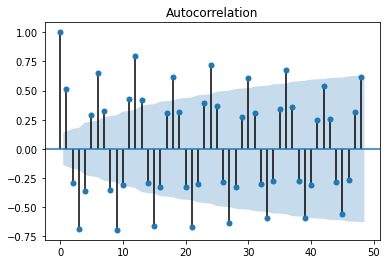

In [32]:
data_m = data_d.resample('M').mean()
sm.graphics.tsa.plot_acf(data_m['PJME_MW'].values[:10000], lags=12*4)
plt.show()

year cicle

**Moving average**

In [33]:
data['d_mov'] = data['PJME_MW'].rolling(window=24).mean()
data['w_mov'] = data['PJME_MW'].rolling(window=24*7).mean()
data['y_mov'] = data['PJME_MW'].rolling(window=24*365).mean()

In [34]:
data.head()

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,PJME_MW no trend,d_mov,w_mov,y_mov
2002-01-01 01:00:00,30393.0,2002,1,1,1,1,1,1,1,-1685.642851,NaN,NaN,NaN
2002-01-01 02:00:00,29265.0,2002,1,1,1,1,1,1,2,-2813.633451,NaN,NaN,NaN
2002-01-01 03:00:00,28357.0,2002,1,1,1,1,1,1,3,-3721.624052,NaN,NaN,NaN
2002-01-01 04:00:00,27899.0,2002,1,1,1,1,1,1,4,-4179.614652,NaN,NaN,NaN
2002-01-01 05:00:00,28057.0,2002,1,1,1,1,1,1,5,-4021.605252,NaN,NaN,NaN


Добавляем первую разность

In [35]:
data['diff1']=data['PJME_MW'].diff(1)

Сбрасываю начало ряда, т.к. признаки Nan из-за сглаживаний

In [36]:
data.dropna(inplace=True)

In [37]:
data.shape

(136637, 14)

Строим примеры с историей р и целевой вектор с предсказанием на h

In [38]:
#добавляем историю длиной р

p =24*7 # будем смотреть на 7 дней назад
h = 24 #предскажем на 24 часа вперед

ПОстроим нормировку данных

In [39]:
scl =StandardScaler()

X_Y = data.values


# смделаем разделение на тесты и обучение
def split_data_b( data, split_date, bias = 0 ):
    # data - input data
    # split_date - number items for train
    return data[:split_date,:].copy(), data[split_date+bias:,:].copy()

split_date=20000 #  number items for train

X_Y_train, X_Y_test = split_data_b( X_Y, split_date, bias = p)

scl = scl.fit(X_Y_train)

scl.scale_[1]=8
scl.mean_[1]=2010
X_Y_train = scl.transform(X_Y_train)
X_Y_test = scl.transform(X_Y_test)

In [40]:
X_Y_test[-10:,0]*scl.scale_[0]+scl.mean_[0]

array([47154., 46989., 46816., 46760., 45641., 44057., 43256., 41552.,
       38500., 35486.])

In [41]:
data.values[-10:,1]

array([2018., 2018., 2018., 2018., 2018., 2018., 2018., 2018., 2018.,
       2018.])

In [42]:
X_train=X_Y_train[:-h,:]
Y_train = X_Y_train[h+p:,0]
X_test = X_Y_test[:-h,:]
Y_test = X_Y_test[h+p:,0]

In [43]:
X_test.shape

(116445, 14)

In [44]:
def sampler_data(X,Y, step=1, sequens_lenght=1,n=1000):
  X_b = []
  Y_b = []
  if n==0:
    n = X.shape[0]-sequens_lenght

  for i in range(n):
    X_b.append(X[i:i+sequens_lenght,:].T.reshape((sequens_lenght*X.shape[1])))
    Y_b.append(Y[i])
  X_b=np.array(X_b)  
  Y_b=np.array(Y_b)
  return X_b,Y_b

Перестроим данные для модели в массив

In [45]:
X_train_b, Y_train_b = sampler_data(X_train,Y_train, step=1, sequens_lenght=p,n=0)
X_test_b, Y_test_b = sampler_data(X_test,Y_test, step=1, sequens_lenght=p,n=0)

In [46]:
X_train_b.shape

(19808, 2352)

Визуальная проверка данных

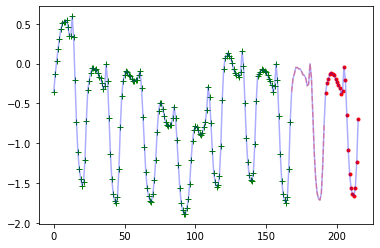

In [48]:
d=h*1
m=(p+h)
plt.plot(range(0+m,d+m),Y_test_b[:d],'.r')


plt.plot(range(0,p),X_test_b[0,:p],'+g')
plt.plot(range(0,d+m),X_test[0:d+m,0],'b',alpha=0.32)
plt.plot(range(p,m),X_test[p:m,0],'--r',alpha=0.32)
plt.show()

In [49]:


print(X_train_b.shape)
print(X_test_b.shape)

(19808, 2352)
(116277, 2352)


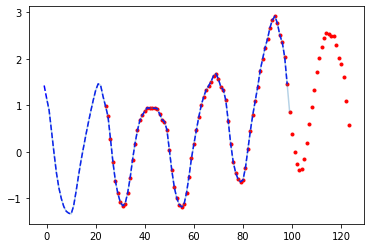

In [50]:
N=100
plt.plot(range(h,h+N),Y_test_b[-N:],'.r')
plt.plot(range(-1,N-1),X_test_b[-N:,p-1],'--b')
plt.plot(X_test[-N:,0],alpha=0.32)
plt.show()


# Отбор признаков

Отбор признаков по f-тесту (признаков очень много, скорее всего хватит и линейной связи)

In [ ]:
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import SelectFromModel

from sklearn.ensemble import GradientBoostingRegressor

from sklearn.feature_selection import f_regression, mutual_info_regression

f_test, _ = f_regression(X_train_b, Y_train_b.ravel())

for i in range(X_train_b.shape[1]):
    print("F-test={:.2f},  I={}".format(f_test[i],i))

Формируем отобранную выборку входных признаков

In [52]:
sfp=SelectPercentile(f_regression, percentile=10)
# fit important feature on train set
X_train_s = sfp.fit_transform(X_train_b, Y_train_b.ravel())
# list of important feature
list_param_m =np.where(sfp.get_support())[0]
# get important feature in test set
X_test_s = X_test_b[:,list_param_m]

X_train_s.shape

(19808, 236)

Покажу в массе разделение на тесты и тренировки по ряду

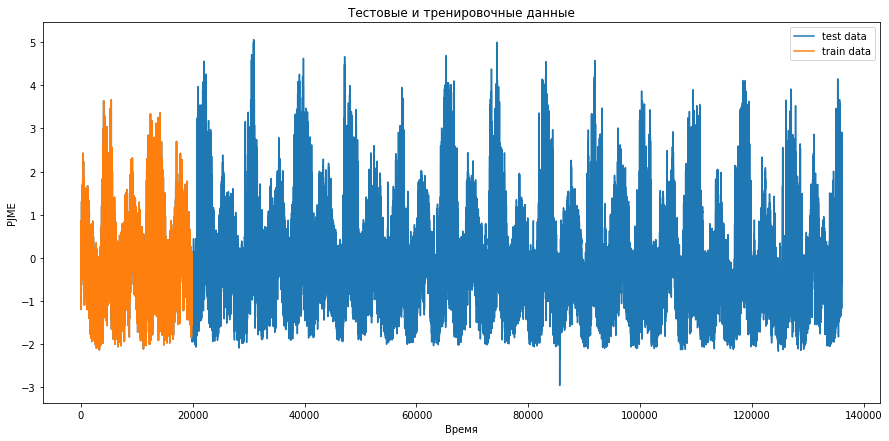

In [53]:
plt.figure( figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('PJME')

plt.plot(np.hstack([Y_train_b,Y_test_b]), label='test data')
plt.plot(Y_train_b, label='train data' )
plt.title( 'Тестовые и тренировочные данные' )
plt.legend()
plt.show()

# Выбор базовой модели

In [54]:
model_g = GradientBoostingRegressor(max_depth=5, random_state=10, n_estimators=100)
model_l = LinearRegression()
model_c = CatBoostRegressor()

Задам функцию для описания модели в LSTM+ConvD1+Dense сети 

In [57]:
def neuro_net(inputs_shape=[1,1,1], lstmlist=[8],convlist=[32,32],denselist=[3]):
  model = Sequential()
  model.add(LSTM(lstmlist[0], input_shape = (inputs_shape[1], inputs_shape[2]), return_sequences="True"))
  if len(lstmlist)==2 :
    model.add(LSTM(lstmlist[1], return_sequences="True"))
  for conv in convlist:
    model.add(Conv1D(conv, 3, activation="linear"))
  
  model.add(Flatten())
  for dens_i in denselist:
    model.add(Dense(dens_i, activation="linear"))
  model.add(Dense(1, activation="linear"))
  model.compile(loss="mse", optimizer="adam", metrics=['mae'])
  return model

callback = EarlyStopping(monitor='val_mae', patience=3)

Строю первичную нейросетевую модель

Epoch 1/10
593/593 [==============================] - 8s 14ms/step - loss: 0.4128 - mae: 0.4908 - val_loss: 0.4774 - val_mae: 0.5655
Epoch 2/10
593/593 [==============================] - 8s 13ms/step - loss: 0.1476 - mae: 0.2994 - val_loss: 0.3444 - val_mae: 0.4694
Epoch 3/10
593/593 [==============================] - 8s 14ms/step - loss: 0.1133 - mae: 0.2609 - val_loss: 0.3827 - val_mae: 0.5053
Epoch 4/10
593/593 [==============================] - 8s 13ms/step - loss: 0.0747 - mae: 0.2107 - val_loss: 0.2850 - val_mae: 0.4200
Epoch 5/10
593/593 [==============================] - 8s 13ms/step - loss: 0.0588 - mae: 0.1877 - val_loss: 0.2814 - val_mae: 0.4315
Epoch 6/10
593/593 [==============================] - 8s 14ms/step - loss: 0.0447 - mae: 0.1620 - val_loss: 0.2529 - val_mae: 0.4117
Epoch 7/10
593/593 [==============================] - 8s 14ms/step - loss: 0.0437 - mae: 0.1633 - val_loss: 0.3261 - val_mae: 0.4896
Epoch 8/10
593/593 [==============================] - 8s 13ms/step - 

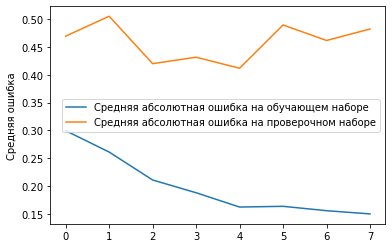

In [58]:

batch_size=32
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    X_train[p:,:],
    Y_train,
    sequence_length=p,
    sampling_rate=5,
    batch_size=batch_size,
)
dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    X_test[-3000:,:],
    Y_test[-3000:],
    sequence_length=p,
    sampling_rate=5,
    batch_size=batch_size,
)
i_s=[batch_size,p,X_test.shape[1]]
model = neuro_net(inputs_shape=[i_s[0],i_s[1],i_s[2]],lstmlist=[8],convlist=[],denselist=[3])
history = model.fit(
    dataset_train,
    epochs=10,
    validation_data=dataset_val,
    callbacks=[callback])


plt.plot(history.history['mae'][1:], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'][1:], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

Для построения первичных моделей сокращаю размер выборки(долго работаетм)

Все первичные модели "из коробки"

In [ ]:
model_l.fit( X_train_s, Y_train_b ) # 
model_g.fit( X_train_s, Y_train_b ) 
model_c.fit( X_train_s, Y_train_b ) 

In [60]:
y_pred_g = model_g.predict(X_train_s[:3000,:])
y_pred_l= model_l.predict(X_train_s[:3000,:])
y_pred_c= model_c.predict(X_train_s[:3000,:])
y_pred_n = model.predict(dataset_train)

y_test_pred_g = model_g.predict(X_test_s[-1000:,:])
y_test_pred_l= model_l.predict(X_test_s[-1000:,:])
y_test_pred_c= model_c.predict(X_test_s[-1000:,:])
y_pred_pred_n = model.predict(dataset_val)

In [61]:
y_pred_pred_n.shape

(2161, 1)

Оценим остатки:

In [63]:
rez_g = Y_test_b[-1000:]-y_test_pred_g
rez_l = Y_test_b[-1000:]--y_test_pred_l
rez_c = Y_test_b[-1000:]--y_test_pred_c
rez_n = Y_test[-3000:-3000+y_pred_pred_n.shape[0]]-y_pred_pred_n.T

In [64]:

from statsmodels.tsa.stattools import adfuller
print('Остатки GBooost не стационарный с вероятностью : ',adfuller(rez_g[:200], regression='ctt')[1])
print('Остатки Linear не стационарный с вероятностью : ',adfuller(rez_l[:200], regression='ctt')[1])
print('Остатки CatBoost не стационарный с вероятностью : ',adfuller(rez_c[:200], regression='ctt')[1])
print('Остатки Net не стационарный с вероятностью : ',adfuller(rez_n[0,:200], regression='ctt')[1])

Остатки GBooost не стационарный с вероятностью :  0.025999437195270283
Остатки Linear не стационарный с вероятностью :  0.8640110237784066
Остатки CatBoost не стационарный с вероятностью :  0.23949493602329386
Остатки Net не стационарный с вероятностью :  0.0178698451565358


In [65]:
print('Остатки GBooost по mae : ',np.mean(np.abs(rez_g[:2000])))
print('Остатки Linear по mae  : ',np.mean(np.abs(rez_l[:2000])))
print('Остатки CatBoost по mae  : ',np.mean(np.abs(rez_c[:2000])))
print('Остатки Net по mae  : ',np.mean(np.abs(rez_n[0,:2000])))

Остатки GBooost по mae :  0.5813128054268074
Остатки Linear по mae  :  2.2146664119456587
Остатки CatBoost по mae  :  2.1533123473150497
Остатки Net по mae  :  0.47344864917515966


Комплексный анализ по качеству остатков и их величине:
 - наиболее стационарные остатки у GB и Net
 - наименьшая ошибка Net - ( и стационарность <0.05 )


Беру в качестве модели Net

Оценим модель:

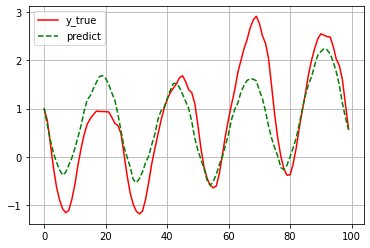

In [71]:
plt.plot(Y_test_b[-100:],'r',label='y_true')
plt.plot(y_pred_pred_n[-100:],'--g',label='predict')
plt.legend()
plt.grid()
plt.show()


# Формируем финальную модель

Результат работы можно еще раз обработать с другим лагом (сезонные циклы не учитывались)


Не буду усложнять - строю финальную модель 

- собираю примеры еще раз
- строю скайлер, и сохраняю его по серелизации
- строю модель
- сохраняю модель


In [72]:
import pickle


filename = 'final_select.sav'
pickle.dump(sfp, open(filename, 'wb'))

In [77]:
from google.colab import files



Сеточный поиск модели

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

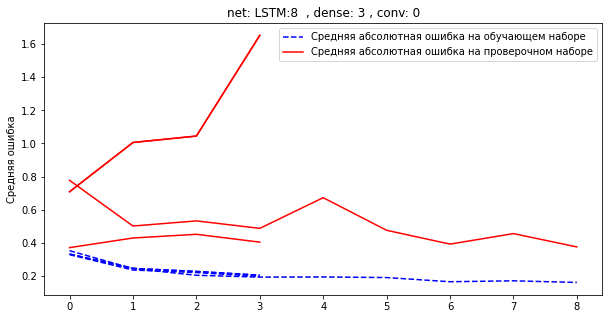

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

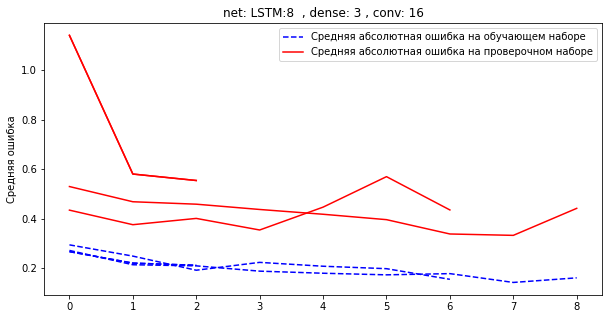

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

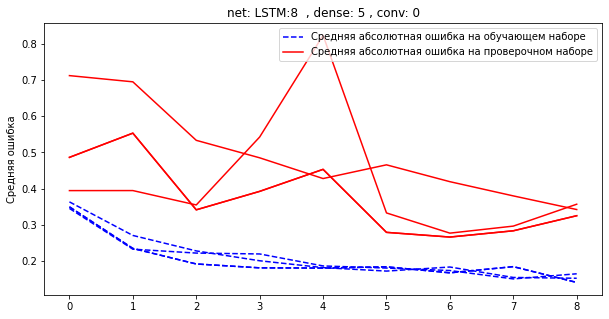

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

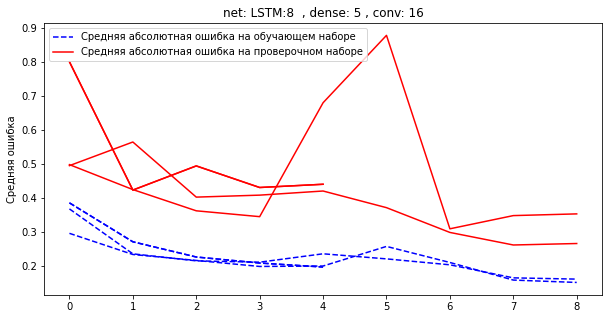

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

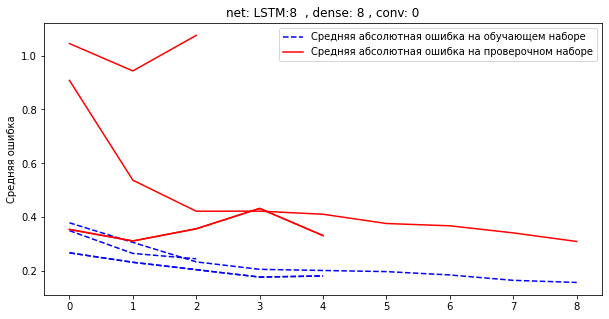

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

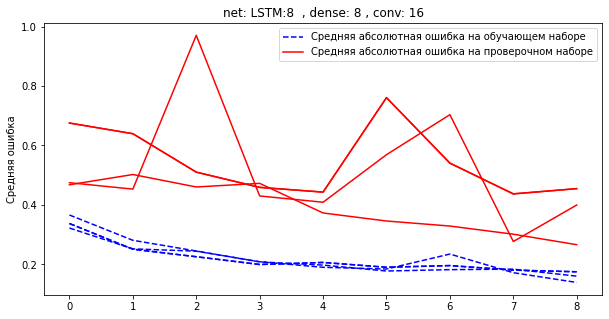

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

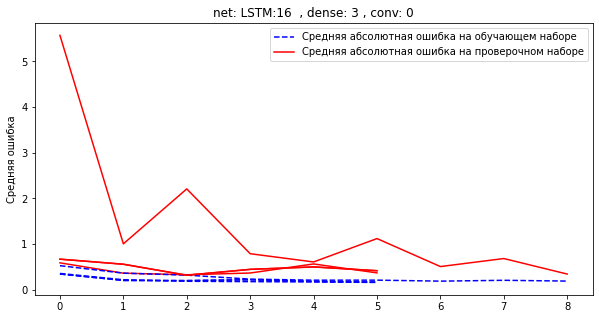

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

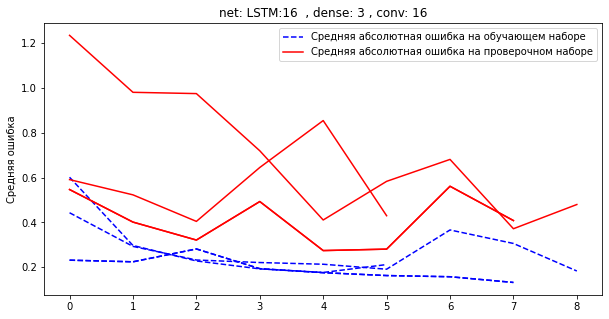

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

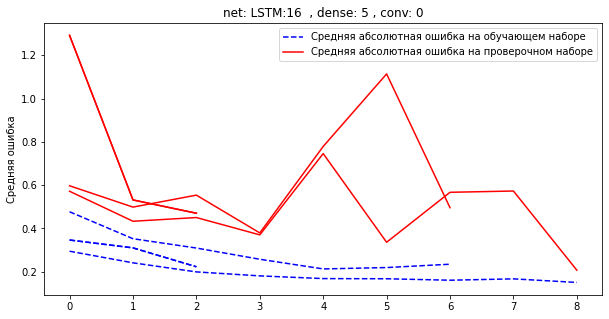

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

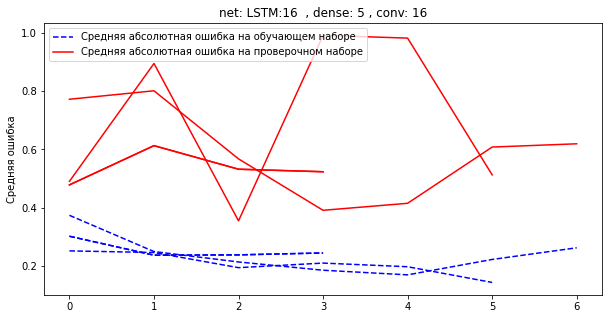

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

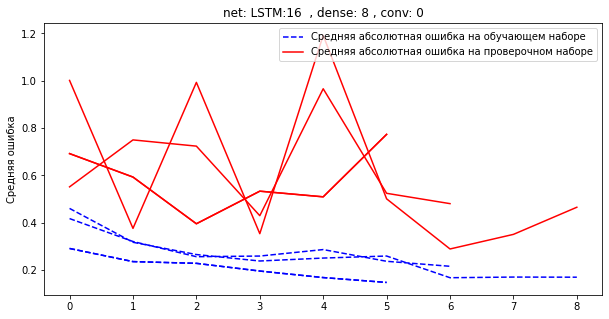

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

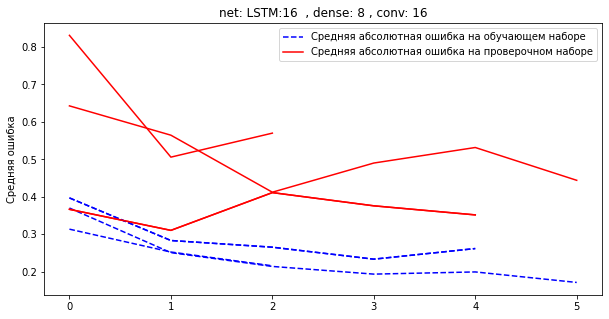

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

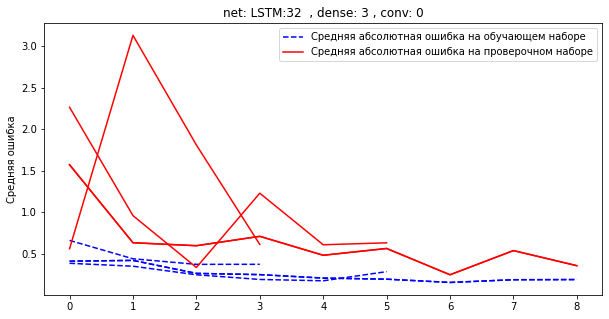

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

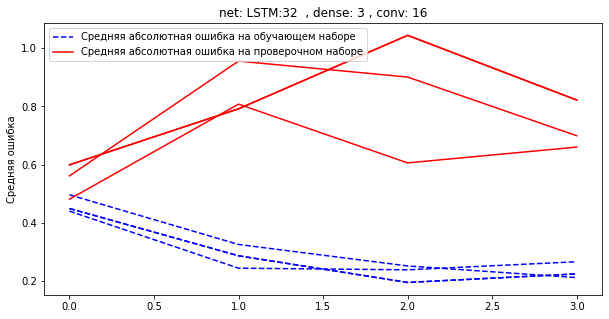

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

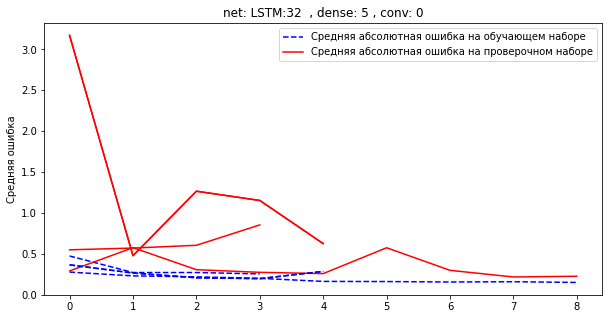

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

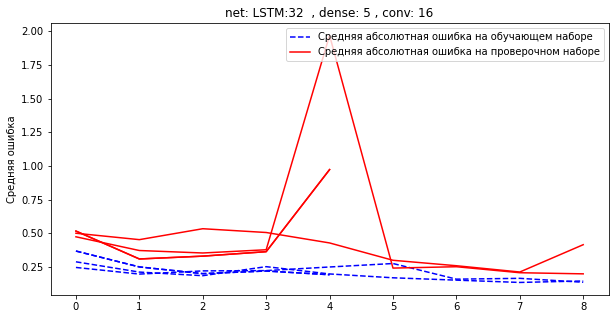

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

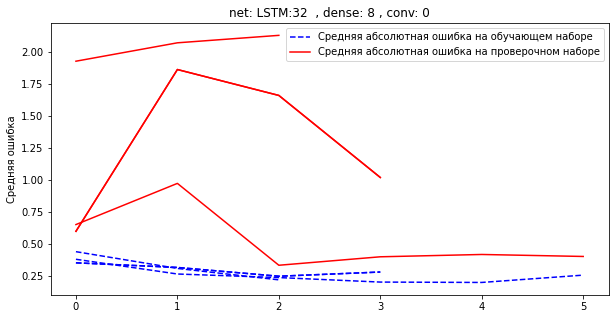

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

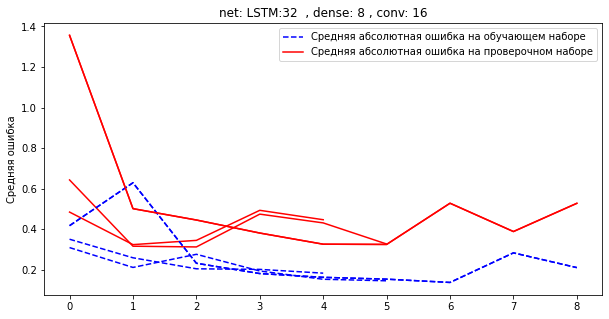

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

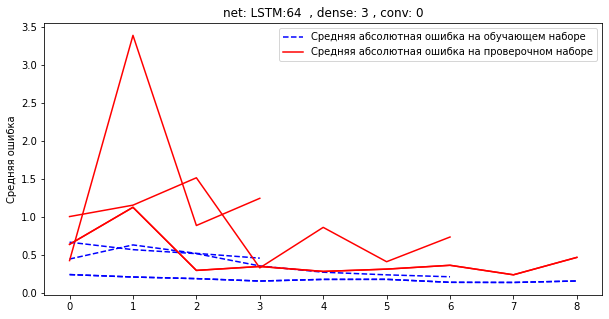

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

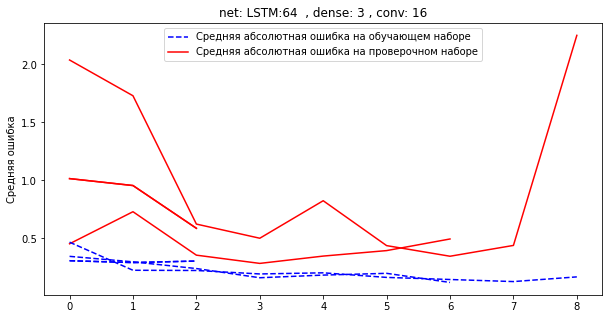

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

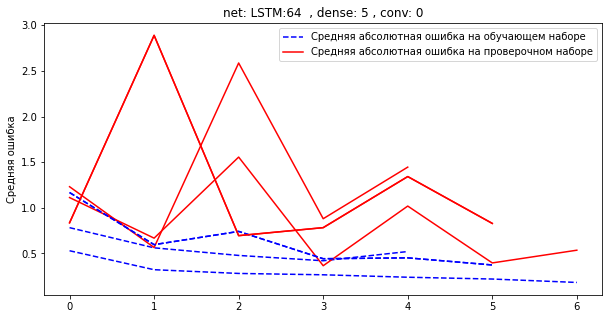

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

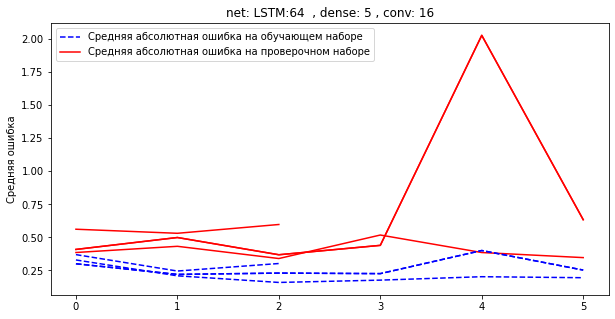

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

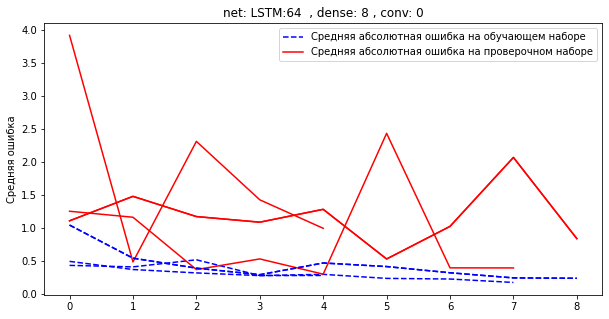

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

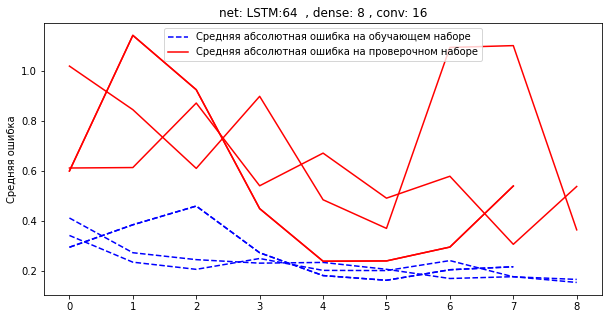

In [90]:
Resume = pd.DataFrame(data=np.array([[0,0,0,0,0]]), columns = ['Lstm','Dense','Conv','train','test'])
k=0
for n_lstm in [8,16,32,64]:
  for n_dense in [3,5,8]:
    for n_conv in [0,16]:
      e_test = []
      e_train = []
      plt.figure(figsize=(10,5))
      for i in range(3):
        if n_conv==0:
          conv_list=[]
        else:
          conv_list=[n_conv]  
        model = neuro_net(inputs_shape=[i_s[0],i_s[1],i_s[2]],lstmlist=[n_lstm],convlist=conv_list,denselist=[n_dense])
        history = model.fit(dataset_train,    epochs=10,    validation_data=dataset_val,    callbacks=[callback], verbose=0)
        e_test.append(history.history['val_mae'][-1])
        e_train.append(history.history['mae'][-1])
        plt.plot(history.history['mae'][1:],'--b' )
        plt.plot(history.history['val_mae'][1:],'r')

      Resume.loc[k,:]=np.array([n_lstm, n_dense,n_conv,np.mean(e_train),np.mean(e_test)])
      k += 1
      Resume.to_csv('res_net.csv')
      files.download('res_net.csv')

      plt.plot(history.history['mae'][1:],'--b', label='Средняя абсолютная ошибка на обучающем наборе')
      plt.plot(history.history['val_mae'][1:],'r',label='Средняя абсолютная ошибка на проверочном наборе')
      plt.ylabel('Средняя ошибка')
      plt.legend()
      plt.title('net: LSTM:'+str(n_lstm)+'  , dense: '+str(n_dense)+' , conv: '+ str(n_conv))
      plt.show()


Результаты поиска:

In [91]:
Resume

,Lstm,Dense,Conv,train,test
0,8.0,3.0,0.0,0.188720,0.811257
1,8.0,3.0,16.0,0.175035,0.476706
2,8.0,5.0,0.0,0.152526,0.341391
3,8.0,5.0,16.0,0.168585,0.352120
4,8.0,8.0,0.0,0.195528,0.572440
5,8.0,8.0,16.0,0.158592,0.373768
6,16.0,3.0,0.0,0.172001,0.376445
7,16.0,3.0,16.0,0.175344,0.439033
8,16.0,5.0,0.0,0.202804,0.391101
9,16.0,5.0,16.0,0.217169,0.551566


Лучший набор параметров

In [92]:
Resume.loc[Resume['test']==np.min(Resume['test'].values),:]

,Lstm,Dense,Conv,train,test
2,8.0,5.0,0.0,0.152526,0.341391


**Финальная модель**

In [94]:
model_final = neuro_net(inputs_shape=[i_s[0],i_s[1],i_s[2]],lstmlist=[8],convlist=[],denselist=[5])

split_date=100000 #  number items for train

X_Y_train, X_Y_test = split_data_b( X_Y, split_date, bias = p)

scl = scl.fit(X_Y_train)

scl.scale_[1]=8
scl.mean_[1]=2010

X_Y_train = scl.transform(X_Y_train)
X_Y_test = scl.transform(X_Y_test)


filename = 'final_scaler.sav'
pickle.dump(scl, open(filename, 'wb'))


X_train=X_Y_train[:-h,:]
Y_train = X_Y_train[h+p:,0]
X_test = X_Y_test[:-h,:]
Y_test = X_Y_test[h+p:,0]


batch_size=32
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
     X_train[p:,:],
    Y_train,
    sequence_length=p,
    sampling_rate=5,
    batch_size=batch_size)
dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    X_test[p:,:],
    Y_test,
    sequence_length=p,
    sampling_rate=5,
    batch_size=batch_size)



In [97]:
from tensorflow.keras.callbacks import ModelCheckpoint

model_checkpoint_callback = ModelCheckpoint(
    filepath='/content/cloned-repo',
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [ ]:


history = model_final.fit(dataset_train,    epochs=100,    validation_data=dataset_val,    callbacks=[callback,model_checkpoint_callback], verbose=0)





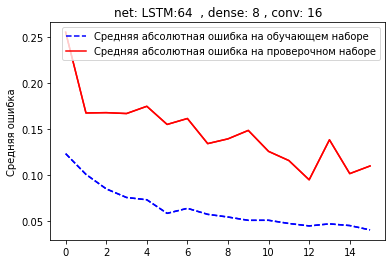

In [99]:
plt.plot(history.history['mae'][1:],'--b' )
plt.plot(history.history['val_mae'][1:],'r')
plt.plot(history.history['mae'][1:],'--b', label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'][1:],'r',label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.title('net: LSTM:'+str(n_lstm)+'  , dense: '+str(n_dense)+' , conv: '+ str(n_conv))
plt.show()

In [100]:
model_final.save_weights('model_weight.h5')

Проверяем предикт

In [101]:
yy=model_final.predict(dataset_val)

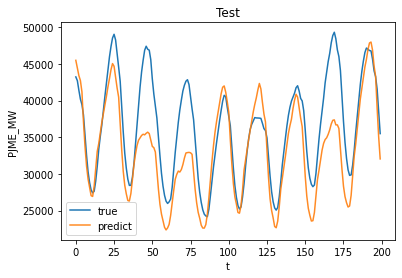

In [107]:
plt.plot(Y_test[-200:]* scl.scale_[0]+scl.mean_[0],label='true')
plt.plot(yy[-200:]* scl.scale_[0]+scl.mean_[0],label='predict', alpha=0.9)

plt.legend()
plt.title('Test')
plt.ylabel('PJME_MW')
plt.xlabel('t')
plt.show()

# Функции для эксплуатации модели

Используем модель:
- строю функцию для обработки признаков для любого куска исходного ряда
- проверяю модель

In [108]:
def feature_make(data,path):
  # clear data
  data['date']=data.index
  data_time_h = pd.date_range(data.index[0],data.index[-1],freq='H')

  time_lost = np.where(np.isin(data_time_h.values, data['date'].values)==False)
  # calculate lost value of consumption
  v = np.round((data.loc[data_time_h[time_lost]-one_hours]['PJME_MW'].values+data.loc[data_time_h[time_lost]+one_hours]['PJME_MW'].values)/2).reshape(-1,1)
  df_data = pd.DataFrame(data = v, index=data_time_h[time_lost],columns=['PJME_MW'])
  df_data['date']=data_time_h[time_lost]

  # conect data and df_data
  data=pd.concat([data,df_data],join = 'inner')
  data.sort_index(inplace=True)
  data.drop_duplicates(inplace=True)

  #New features

  data['year'] = data['date'].dt.year
  data['month'] = data['date'].dt.month
  data['dayofmonth'] = data['date'].dt.day
  data['quarter'] = data['date'].dt.quarter
  data['dayofyear'] = data['date'].dt.dayofyear
  data['weekofyear'] = data['date'].dt.weekofyear
  data['dayofweek'] = data['date'].dt.dayofweek
  data['hour'] = data['date'].dt.hour
  data.drop( columns = 'date', inplace = True )


  W0,W1 = 32078.642851247627, -0.009399857149792397

  y= data['PJME_MW'].values
  all_data_time_h = pd.date_range('2002-01-01 01:00:00',data.index[-1],freq='H')
  ind = np.where(all_data_time_h == data.index[0] )[0]
  #print(ind[0],all_data_time_h.shape[0])
  x1 = np.array(range(ind[0],all_data_time_h.shape[0]+100))
  y1=W0-W1*x1
  data['PJME_MW no trend'] = y - y1[:y.shape[0]]


  data['d_mov'] = data['PJME_MW'].rolling(window=24).mean()
  data['w_mov'] = data['PJME_MW'].rolling(window=24*7).mean()
  data['y_mov'] = data['PJME_MW'].rolling(window=24*365).mean()

  data['diff1']=data['PJME_MW'].diff(1)

  data.dropna(inplace=True)
  # model parametr
  p=24*7
  h=24
  #print(data.iloc[-h:,:])

  X_Y = data.values
  #print(X_Y.shape)
  filename = path+'final_scaler.sav'
  scl=pickle.load(open(filename, 'rb'))

  X_Y_test = scl.transform(X_Y)

  X_test = X_Y_test[:-h,:]
  Y_test = X_Y_test[h+p:,0]


  batch_size=32

  dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    X_test[p:,:],
    Y_test,
    sequence_length=p,
    sampling_rate=5,
    batch_size=batch_size)

  return dataset_val, scl


In [ ]:
/content/model_weight.h5

In [112]:
def model_work(data,  path):
  model_final = neuro_net(inputs_shape=[i_s[0],i_s[1],i_s[2]],lstmlist=[8],convlist=[],denselist=[5])
  model_final.load_weights(path+'model_weight.h5')
  X, scl=feature_make(data,path)

  Y = model_final.predict(X)
  #print(scl.scale_[0],scl.mean_[0],Y)
  return Y*scl.scale_[0]+scl.mean_[0]


# Проверка функций

читаем заново данные из набора PJWE_MW

In [110]:
data_test = pd.read_csv(Path_Energy, index_col=[0], parse_dates=[0])


data_test.sort_index(inplace=True)
#data.drop('Time',axis=1, inplace =True)
data_test.head()

,PJME_MW
Datetime,
2002-01-01 01:00:00,30393.0
2002-01-01 02:00:00,29265.0
2002-01-01 03:00:00,28357.0
2002-01-01 04:00:00,27899.0
2002-01-01 05:00:00,28057.0


Для теста берем конец данных (оцениваем , то на чем не учили)

In [144]:
t=5
T = 20000

y_work=model_work(data_test.iloc[-T-t:-t], '/content/')

Формируем истиные данные (кусок из значений)

In [145]:
y_test = data_test.iloc[-T-t-h-1:-T-t-1+h*8,0].values

Отображаем

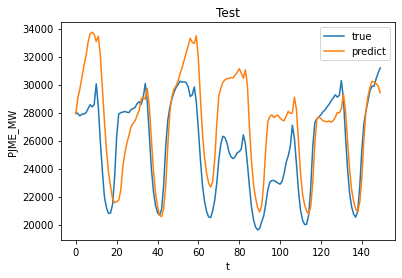

In [149]:
plt.plot(y_test[:150],label='true')
plt.plot(y_work[:150],label='predict')
plt.legend()
plt.title('Test')
plt.ylabel('PJME_MW')
plt.xlabel('t')
plt.show()

Оценка MAPE:

In [151]:
MAPE_y= np.mean(np.abs(y_test[:y_work.shape[0]].reshape(-1,1)-y_work[:,0])/y_work[:,0])*100
print('Ошибка МАРЕ:'+str(MAPE_y)+'%')


Ошибка МАРЕ:19.880110831602053%
